Загрузка данных

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [13]:
try:
    full_df = pd.read_csv('train.csv')
    print("Данные успешно загружены")
    print(f"Размер полного набора: {full_df.shape}")

    from sklearn.model_selection import train_test_split

    X = full_df.iloc[:, :-1]  # В
    y = full_df.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    print(f"Обучающая выборка: {X_train.shape}")
    print(f"Тестовая выборка: {X_test.shape}")
    print(f"Целевая переменная - распределение:")
    print(f"  Train: min={y_train.min():.2f}, max={y_train.max():.2f}, mean={y_train.mean():.2f}")
    print(f"  Test:  min={y_test.min():.2f}, max={y_test.max():.2f}, mean={y_test.mean():.2f}")

except FileNotFoundError:
    print("Файл train.csv не найден. Используем демонстрационные данные")
    from sklearn.datasets import fetch_california_housing
    from sklearn.model_selection import train_test_split

    data = fetch_california_housing()
    X = data.data
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

    print(f"Демо данные: X_train {X_train.shape}, X_test {X_test.shape}")

Данные успешно загружены
Размер полного набора: (1460, 81)
Обучающая выборка: (1168, 80)
Тестовая выборка: (292, 80)
Целевая переменная - распределение:
  Train: min=34900.00, max=745000.00, mean=181441.54
  Test:  min=35311.00, max=755000.00, mean=178839.81


Исследование данных


АНАЛИЗ ДАННЫХ
ПОЛНЫЙ НАБОР ДАННЫХ:
Размер: (1460, 81)
Первые 5 строк:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12  

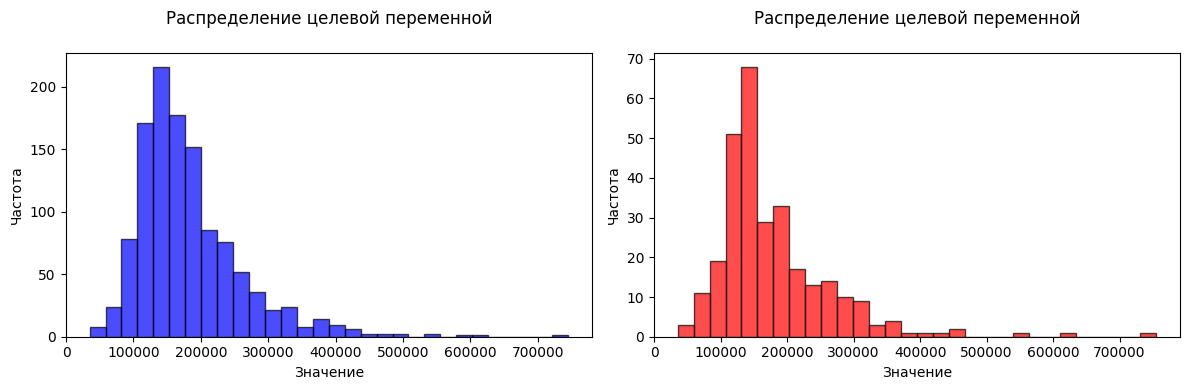

In [14]:
print("\n" + "=" * 50)
print("АНАЛИЗ ДАННЫХ")
print("=" * 50)

print("ПОЛНЫЙ НАБОР ДАННЫХ:")
print(f"Размер: {full_df.shape}")
print("Первые 5 строк:"); print(full_df.head())
print("Последние 5 строк:"); print(full_df.tail())
print("Информация:"); full_df.info()
print("Статистика:"); print(full_df.describe())
print(f"Пропуски: {full_df.isnull().sum().sum()}, Дубликаты: {full_df.duplicated().sum()}")

print("\nОБУЧАЮЩАЯ ВЫБОРКА:")
print(f"Размер: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Пропуски: {X_train.isnull().sum().sum()}")

print("\nТЕСТОВАЯ ВЫБОРКА:")
print(f"Размер: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Пропуски: {X_test.isnull().sum().sum()}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение целевой переменной\n')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Распределение целевой переменной\n')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Предобработка данных

In [15]:
print("\n" + "=" * 50)
print("ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 50)

print("РАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Удаление дубликатов
X_train = X_train.drop_duplicates()
X_test = X_test.drop_duplicates()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

print(f"После удаления дубликатов: X_train {X_train.shape}, X_test {X_test.shape}")

# Анализ типов данных
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

print(f"\nЧисловых колонок: {len(numeric_cols)}")
print(f"Категориальных колонок: {len(categorical_cols)}")

# Обработка пропусков
print("\nОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")

for col in numeric_cols:
    train_missing = X_train[col].isnull().sum()
    test_missing = X_test[col].isnull().sum()
    if train_missing > 0 or test_missing > 0:
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)
        print(f"  {col}: заполнено {train_missing}(train)+{test_missing}(test) пропусков медианой {median_val:.2f}")

for col in categorical_cols:
    train_missing = X_train[col].isnull().sum()
    test_missing = X_test[col].isnull().sum()
    if train_missing > 0 or test_missing > 0:
        mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col] = X_train[col].fillna(mode_val)
        X_test[col] = X_test[col].fillna(mode_val)
        print(f"  {col}: заполнено {train_missing}(train)+{test_missing}(test) пропусков модой '{mode_val}'")

# Кодирование категориальных признаков
print("\nКОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")

for col in categorical_cols:
    unique_vals = X_train[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений")

    if unique_vals <= 10:
        X_train = pd.get_dummies(X_train, columns=[col], prefix=col)
        X_test = pd.get_dummies(X_test, columns=[col], prefix=col)
    else:
        le = LabelEncoder()
        all_categories = pd.concat([X_train[col], X_test[col]], axis=0).unique()
        le.fit(all_categories)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

# Выравнивание колонок
print("\nВЫРАВНИВАНИЕ КОЛОНОК:")
common_cols = list(set(X_train.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"Общих колонок после обработки: {len(common_cols)}")

# УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ
print("\n" + "-" * 40)
print("УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ")
print("-" * 40)

numeric_cols_for_corr = X_train.select_dtypes(include=[np.number]).columns

if len(numeric_cols_for_corr) > 1:
    corr_matrix = X_train[numeric_cols_for_corr].corr().abs()

    upper_triangle = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    high_corr_features = [column for column in upper_triangle.columns
                         if any(upper_triangle[column] > 0.8)]

    print(f"Найдено высококоррелированных признаков (>0.8): {len(high_corr_features)}")

    if high_corr_features:
        print("Высококоррелированные признаки для удаления:")
        for feature in high_corr_features:
            corr_with = upper_triangle[feature][upper_triangle[feature] > 0.8]
            corr_pairs = [f"{col}({corr:.2f})" for col, corr in corr_with.items()]
            print(f"  {feature} коррелирует с: {', '.join(corr_pairs)}")

        # Удаляем высококоррелированные признаки
        X_train = X_train.drop(columns=high_corr_features)
        X_test = X_test.drop(columns=high_corr_features)
        print(f"Удалено {len(high_corr_features)} коррелирующих признаков")
    else:
        print("Высококоррелированные признаки не найдены")
else:
    print("Недостаточно числовых признаков для анализа корреляции")

print(f"После удаления коррелирующих признаков: X_train {X_train.shape}, X_test {X_test.shape}")

# Масштабирование
print("\nМАСШТАБИРОВАНИЕ ПРИЗНАКОВ:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Финальный размер данных:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")
print("Предобработка завершена ")


ПРЕДОБРАБОТКА ДАННЫХ
РАЗДЕЛЕНИЕ ДАННЫХ:
X_train: (1168, 80), y_train: (1168,)
X_test: (292, 80), y_test: (292,)
После удаления дубликатов: X_train (1168, 80), X_test (292, 80)

Числовых колонок: 37
Категориальных колонок: 43

ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
  LotFrontage: заполнено 217(train)+42(test) пропусков медианой 70.00
  MasVnrArea: заполнено 6(train)+2(test) пропусков медианой 0.00
  GarageYrBlt: заполнено 64(train)+17(test) пропусков медианой 1980.00
  Alley: заполнено 1094(train)+275(test) пропусков модой 'Grvl'
  MasVnrType: заполнено 683(train)+189(test) пропусков модой 'BrkFace'
  BsmtQual: заполнено 28(train)+9(test) пропусков модой 'TA'
  BsmtCond: заполнено 28(train)+9(test) пропусков модой 'TA'
  BsmtExposure: заполнено 28(train)+10(test) пропусков модой 'No'
  BsmtFinType1: заполнено 28(train)+9(test) пропусков модой 'Unf'
  BsmtFinType2: заполнено 28(train)+10(test) пропусков модой 'Unf'
  Electrical: заполнено 1(train)+0(test) пропусков модой 'SBrkr'
  FireplaceQu:

Построение нейронной сети

In [16]:
print("\n" + "=" * 50)
print("ПОСТРОЕНИЕ НЕЙРОННОЙ СЕТИ")
print("=" * 50)

# Создание модели
def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Выходной слой для регрессии
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Создание и вывод модели
model = create_model(X_train_scaled.shape[1])
print("Архитектура модели:")
model.summary()


ПОСТРОЕНИЕ НЕЙРОННОЙ СЕТИ
Архитектура модели:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        25,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,585 (139.00 KB)

 Trainable params: 35,585 (139.00 KB)

 Non-trainable params: 0 (0.00 B)

Обучение модели

In [17]:
print("\n" + "=" * 50)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 50)

# Callback для ранней остановки
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Обучение
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


ОБУЧЕНИЕ МОДЕЛИ
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 38056935424.0000 - mae: 179144.3594 - val_loss: 37831995392.0000 - val_mae: 181077.4219
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39370903552.0000 - mae: 182284.6875 - val_loss: 37765746688.0000 - val_mae: 180930.6875
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38663741440.0000 - mae: 180625.5000 - val_loss: 37437464576.0000 - val_mae: 180224.7812
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38636023808.0000 - mae: 179629.1094 - val_loss: 36386230272.0000 - val_mae: 177947.9531
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37998247936.0000 - mae: 179317.3281 - val_loss: 33768790016.0000 - val_mae: 172077.3906
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33037613056.0000 - mae: 168184.7031 - val_loss: 28795017216.0000 - val_mae: 159957.8906
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26245117952.0000 - mae: 151741.5625 - val

Визуализация процесса обучения

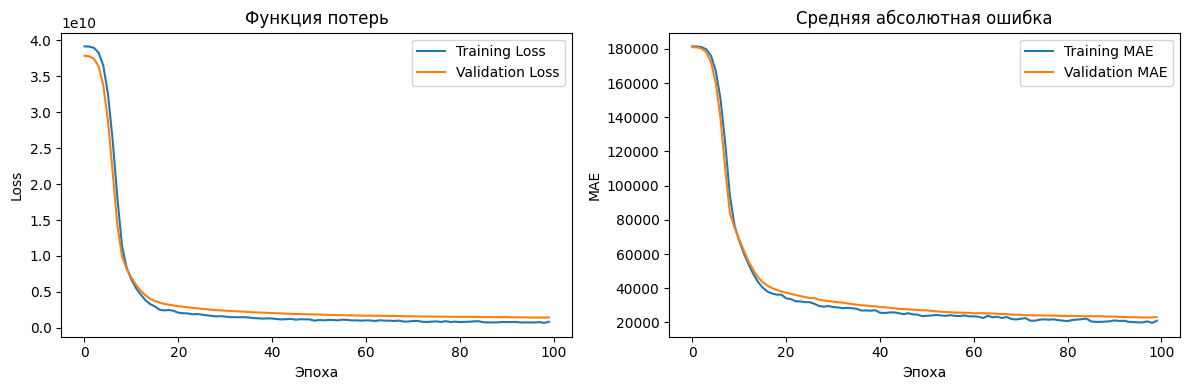

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Оценка модели


ОЦЕНКА МОДЕЛИ
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Тип y_test: <class 'pandas.core.series.Series'>
Тип y_pred: <class 'numpy.ndarray'>
Уникальные значения в y_test: [154500 325000 115000 159000 315500  75500 311500 146000  84500 135500]
y_test_encoded shape: (292,)
y_pred shape: (292,)
Результаты на тестовых данных:
Mean Squared Error (MSE): 1280821888.0000
Root Mean Squared Error (RMSE): 35788.5720
Mean Absolute Error (MAE): 24487.0957


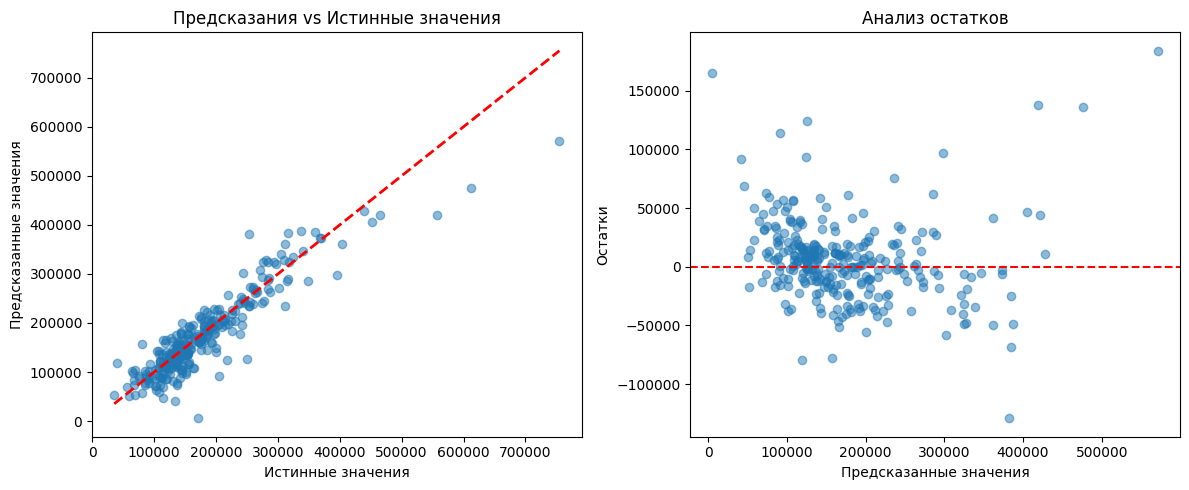


Распределение целевой переменной:
Min: 35311.00, Max: 755000.00, Mean: 178839.81


In [19]:
print("\n" + "=" * 50)
print("ОЦЕНКА МОДЕЛИ")
print("=" * 50)

y_pred = model.predict(X_test_scaled).flatten()

print(f"Тип y_test: {type(y_test)}")
print(f"Тип y_pred: {type(y_pred)}")
print(f"Уникальные значения в y_test: {y_test.unique()[:10]}")

if y_test.dtype == 'object':
    print("Преобразуем целевую переменную в числовой формат...")
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
else:
    y_test_encoded = y_test.values

print(f"y_test_encoded shape: {y_test_encoded.shape}")
print(f"y_pred shape: {y_pred.shape}")

# Метрики
try:
    mse = mean_squared_error(y_test_encoded, y_pred)
    mae = mean_absolute_error(y_test_encoded, y_pred)
    rmse = np.sqrt(mse)

    print(f"Результаты на тестовых данных:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
except Exception as e:
    print(f"Ошибка при расчете метрик: {e}")

# Визуализация предсказаний
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_encoded, y_pred, alpha=0.5)
plt.plot([y_test_encoded.min(), y_test_encoded.max()],
         [y_test_encoded.min(), y_test_encoded.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Истинные значения')

plt.subplot(1, 2, 2)
residuals = y_test_encoded - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')

plt.tight_layout()
plt.show()

# Дополнительная информация о распределении целевой переменной
print("\nРаспределение целевой переменной:")
if y_test.dtype == 'object':
    print(pd.Series(y_test).value_counts())
else:
    print(f"Min: {y_test.min():.2f}, Max: {y_test.max():.2f}, Mean: {y_test.mean():.2f}")

Анализ важности признаков


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
Количество признаков: 36
Размерность весов: (196, 128)
Количество важностей: 196
Несоответствие размеров: признаки 36, важности 196

Топ-10 важных признаков:
          feature  importance
25   BedroomAbvGr    0.576191
28       PoolArea    0.541102
22  EnclosedPorch    0.519347
12       FullBath    0.505934
15      YearBuilt    0.403131
0      MSSubClass    0.387264
4        1stFlrSF    0.366172
1     LotFrontage    0.333466
24        MiscVal    0.313294
11   Neighborhood    0.290334


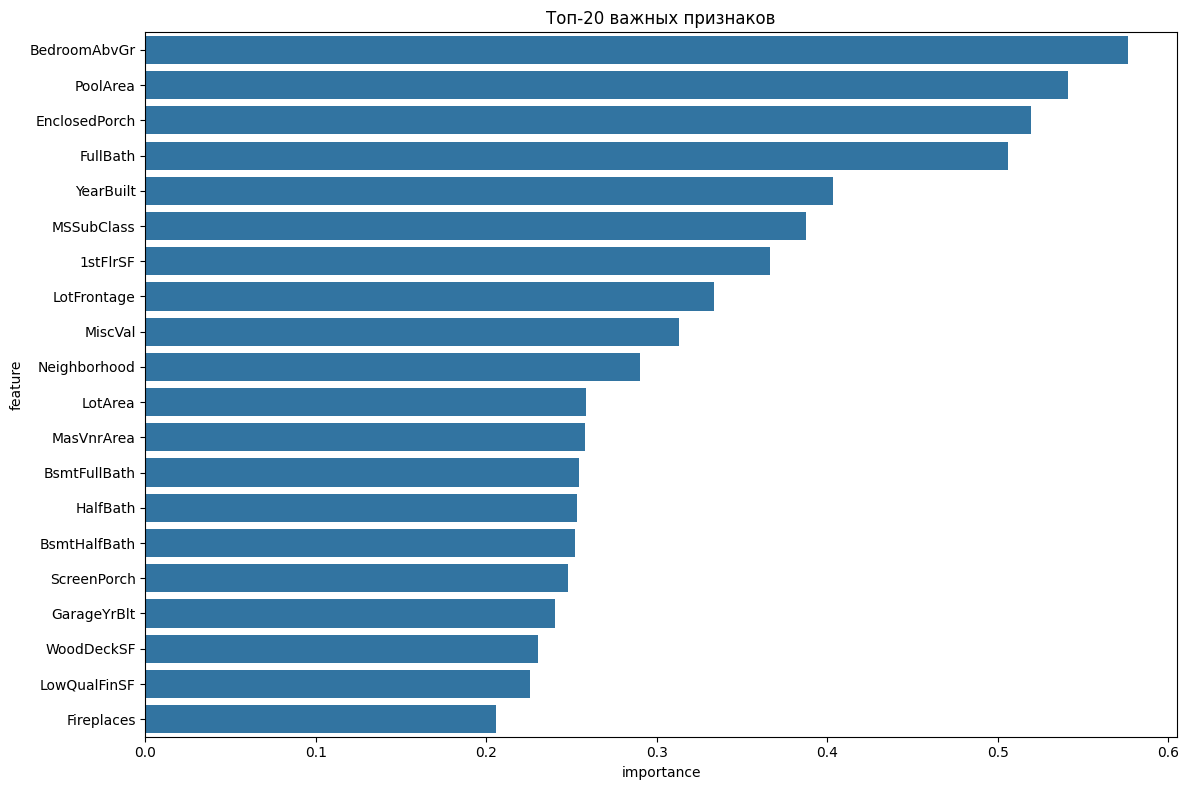

In [22]:
print("\n" + "=" * 50)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 50)

# Получаем названия признаков после обработки
if 'X_train_processed' in locals() and hasattr(X_train_processed, 'columns'):
    feature_names = X_train_processed.columns.tolist()
elif 'X_train_numeric' in locals() and hasattr(X_train_numeric, 'columns'):
    feature_names = X_train_numeric.columns.tolist()
else:
    feature_names = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Количество признаков: {len(feature_names)}")

# Получение весов из модели
try:
    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)

    print(f"Размерность весов: {weights.shape}")
    print(f"Количество важностей: {len(feature_importance)}")

    if len(feature_importance) != len(feature_names):
        print(f"Несоответствие размеров: признаки {len(feature_names)}, важности {len(feature_importance)}")

        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_importance = feature_importance[:len(feature_names)]

    # Создание DataFrame для визуализации
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nТоп-10 важных признаков:")
    print(importance_df.head(10))

    # Визуализация важности признаков (топ-20)
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Топ-20 важных признаков')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ошибка при анализе важности признаков: {e}")
    print("Пропускаем анализ важности признаков")